# ***DATA ANALYSIS THROUGH THE KALMAM FILTER***

*Authors*

*   De Angelis Valentina
*   Intoccia Gabriele



# **Abstract**
In this work, the Kalman filter was implemented on experimental data collected by GPS and accelerometers. In particular, the circumflegrea section from Pianura to Pisani was considered. The dataset was imported from Google Drive and first, after importing the data on the position of the train, this information was plotted to get an overall picture of the route. In this way, a section of the tunnel was detected in which the GPS system doesn't work well and on which to apply the filter and make our considerations.
We then analyzed the Fourier transform of the accelerations in order to reduce the frequencies representing the acceleration when cornering, through filtering techniques.

# **Dataset documentation**
The dataset has been built by IMU data and GPS, collected by IVM S.r.l.. The data belong to 4 different references systems :

*   Train reference system centered in the sensor IMU position: x, y, z;
*   Inertial reference system which corrisponde to the train's binary: x, y, z;
*  Earth refernce system ENU: east, nord, up;
*  Geodetics coordinates: longitude, latitude, height at sea level.

To move from one to the other, transformations based on rotation matrices have been and can be used, such as
described in the references provided.

Other features of the dataset are given by the following table:

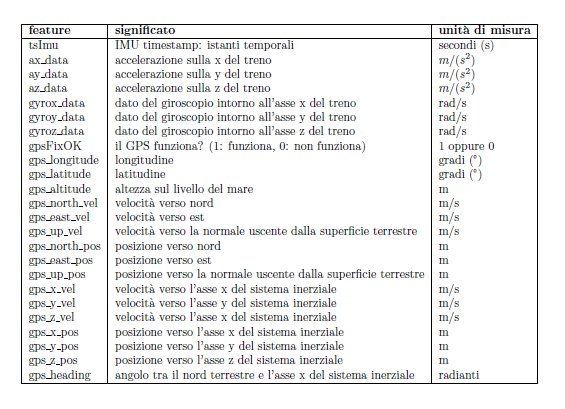




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


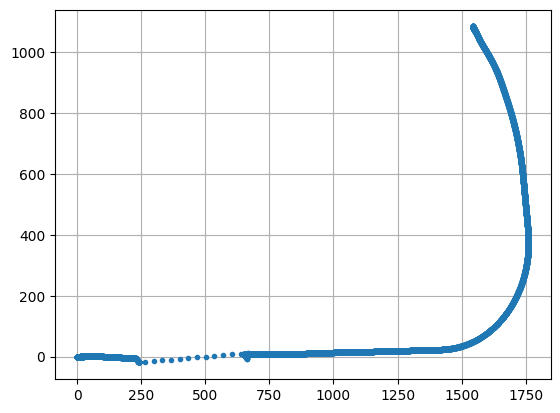

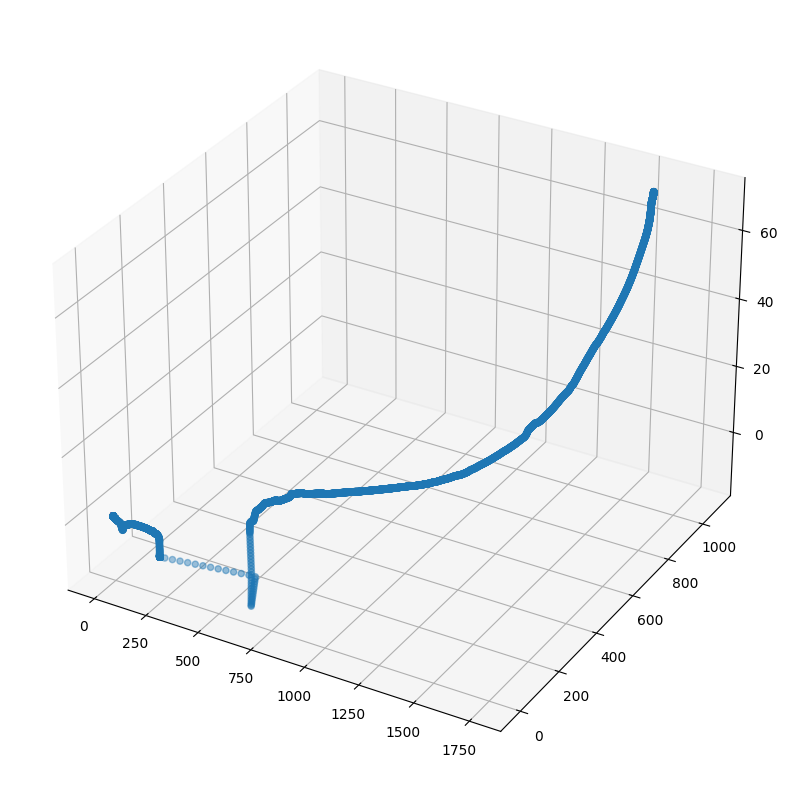

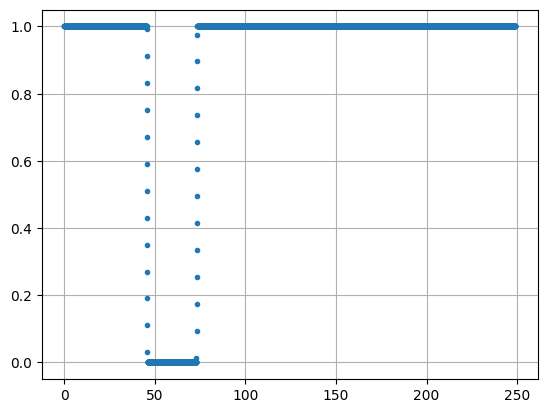

In [ ]:
import scipy as sc
import numpy as np
import math as m
from matplotlib import pyplot as plt
import pickle
from google.colab import drive
import gzip
import pandas as pd
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D

#Loading the dataset from Drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/train_dataset.pkl"
file = open(DATA_PATH, 'rb')
pickle.load(file)
train_set = pd.read_pickle(DATA_PATH)

#Inertial reference system positions (tracks)
gpsx, gpsy, gpsz = train_set['gps_x_pos'], train_set['gps_y_pos'], train_set['gps_z_pos']

#Plot 2D position
plt.plot(gpsx,gpsy, '.')
plt.grid()
plt.show()

#Plot 3D positions
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gpsx,gpsy,gpsz)
plt.show()

#Time
time=train_set['tsImu']


#GPS positions terrestrial reference system
gpsn, gpse, gpsup = train_set['gps_north_pos'], train_set['gps_east_pos'], train_set['gps_up_pos']

#Plot of GPS operation as a function of time
GPSfix= train_set['gpsFixOK']
plt.plot(time,GPSfix, '.')
plt.grid()
plt.show()

#GPS speed
gpsxvel, gpsyvel, gpszvel = train_set['gps_x_vel'], train_set['gps_y_vel'], train_set['gps_z_vel']

#Creation of the X vector of GPS positions (inertial reference system)
X=np.array([gpsx,gpsy,gpsz])
X=np.transpose(X)

#Creation of the V vector of GPS velocities (inertial ref. system)
V=np.array([gpsxvel, gpsyvel, gpszvel]).T

#Accelerations
ax, ay, az = train_set['ax_data'], train_set['ay_data'], train_set['az_data']

#Creation of vector A of accelerations (measured by accelerometers)
A=np.array([ax, ay, az])
A=np.transpose(A)

#GPS geodetic coordinates
gpslong, gpslat, gpsalt = train_set['gps_longitude'], train_set['gps_latitude'], train_set['gps_altitude']

#Gyroscope angular speeds
gyrox, gyroy, gyroz = train_set['gyrox_data'], train_set['gyroy_data'], train_set['gyroz_data']


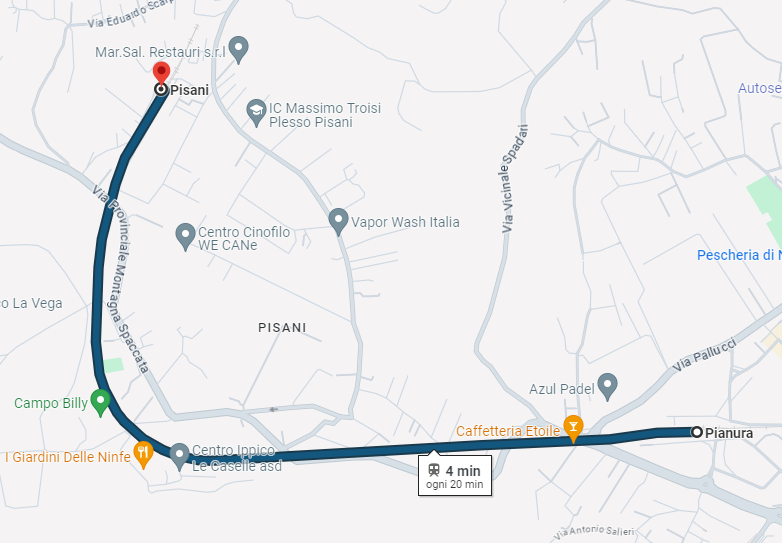

# **An introduction to the Kalman filter**
Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccurancies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe. The filter is named after Rudolf E. Kálmán, one of the primary developers of its theory.

The algorithm works by a two-phase process having a prediction phase and an update phase. For the prediction phase, the Kalman filter produces estimates of the current state variables, along with their uncertainties. Once the outcome of the next measurement (necessarily corrupted with some error, including random noise) is observed, these estimates are updated using a weighted average, with more weight being given to estimates with greater certainty. The algorithm is recursive. It can operate in real time, using only the present input measurements and the state calculated previously and its uncertainty matrix; no additional past information is required.

Optimality of Kalman filtering assumes that errors have a normal (Gaussian) distribution:

$f(x)= \frac{1}{\sqrt{2\pi \sigma}} \exp\Bigg(-\frac{(x-\mu)^2}{2\sigma^2}\Bigg)$

To understand the Kalman filter, we need to introduce the Bayes filter. This one use the Bayes rule which describes the probability of an event, $a$, based on prior knowledge of conditions, $b$, that might be related to $a$.

$p(a|b)=\eta p(b|a)p(a)$

where $\eta$ is a normalization factor.

The Bayes filter needs data such as:

*   $z$ — sensor observation;
*   $u$ — control data;
*   $x$ — state of the system .

Since we know the sensor observation, $z$, and the control data, $u$, only the state of the system, $x$, is unknown. Using the Bayes rule, we arrived a 2 equations. In the prediction step, we are dealing only with the control data and the previous state of the system. The control data has to be modeled, and for that, we use the motion model:

$\overline {bel}(x_t)=\int_{x_{t-1}}p(x_t|x_{t-1},u_t)bel(x_{t-1})dx_{t-1}$

The same applies to the update step but to the sensor observations. If we can update the state of the system, with the sensor observation modeled properly, we can correct the prediction. So,

$bel(x_t)=\eta p(z_t|x_t) \overline {bel}(x_t)$

We now have mathematical representations of the predict and update steps.

Kalman filter is one way of realising the Bayes Filter. It is a Bayes Filter with 2 assumptions: all distributions are Gaussian;
both the state extrapolation (motion) model and measurement (observation) model are linear (or linearized).
The Kalman filter provides a specific solution to the Bayes filter problem for linear dynamic systems with Gaussian noise. It assumes that both the system dynamics and measurement models are linear and that the noise follows a Gaussian distribution with known statistics. The Kalman filter uses a two-step process: a prediction step and an update step, as we already presented. By iteratively applying the prediction and update steps, the Kalman filter provides an efficient and optimal solution to estimate the state of a linear system given noisy measurements. It continuously refines the state estimate as new measurements become available.

# **Explanation of the Kalman filter**
# Assumption for Linearity
The Kalman filter assumes a linear motion and observation model. Therefore, we can represent our state (motion model) and measurement (measurement model) with the following equations respectively:


*   $x_t=A_t x_{t-1}+B_t u_t + \epsilon_t$
*   $z_t=C_tx_t+\delta_t$

**Variable definitions**

1. Matrix $A_t$: describes how the system state evolves from $t-1$ to $t$ without controls or noise. It is a $(n × n)$ matrix, where $n$ is the dimension of the state vector;
2. Matrix $B_t$: describes how the control $u_t$ changes the state from $t-1$ to $t$. It is an $(n × l)$ matrix, where $n$ is the dimension of the state vector and $l$ is the dimension of the control command vector;
3. Matrix $C_t$: describes how to map the state $x_t$ to an observation $z_t$. It is a $(k × n)$ matrix, where $n$ is the dimension of the state vector and $k$ is the dimension of the observation vector. You can also see this matrix as the following question:” What should I expect to observe given that the world is in its current state?”;
4. $ε_t$ and $δ_t$: random variables representing the process (motion) and measurement noise. They are assumed to be independent and normally distributed with covariance $R_t$ and $Q_t$ respectively.

**Assumption for Gaussian distributions**
the equation of a generic multivariate Gaussian distribution is:

$ p(x)= det(2\pi\Sigma)^{-\frac{1}{2}}exp\{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\}$

where $\mu$ is the mean and $\Sigma$ the covariance matrix. The covariance is a quadratic matrix that is symmetric and positive-semidefinite. Its dimension equals the dimensionality of the state $x$ squared $(m × m)$. Applying this model to the Bayes filter, we arrive to:

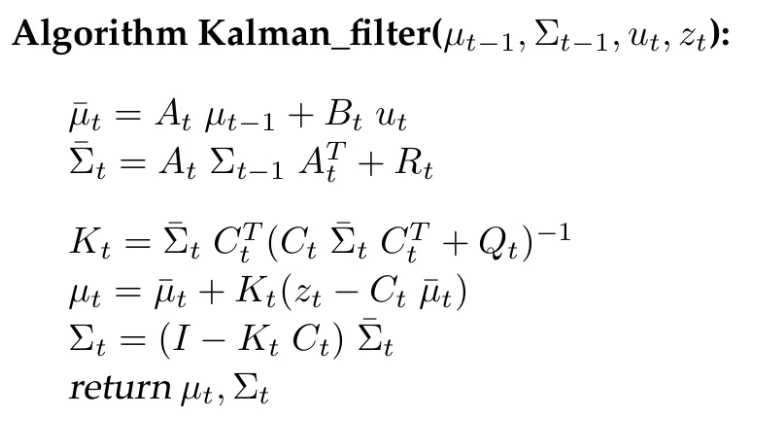

where $K_t$ is a weigth called Kalman gain.


# Preliminary studies
Our purpose is to find the train's position in the gallery.
To implement the update of Kalman filter, we need exact data. For this reason, in order to find theoretical data on the position of the train in the tunnel, we searched for a polynomial that would fit our real data. This was done for positions on all 3 axes.



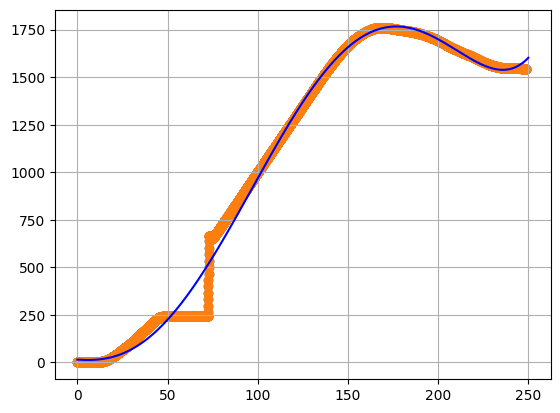

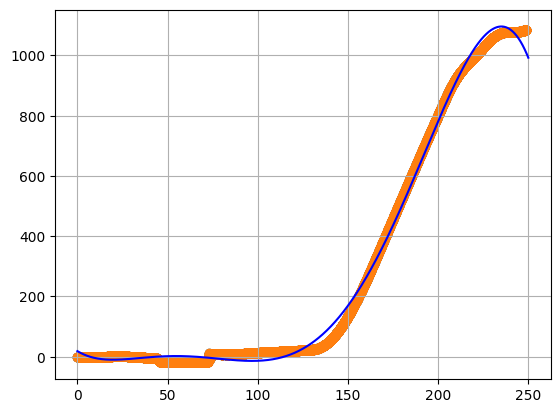

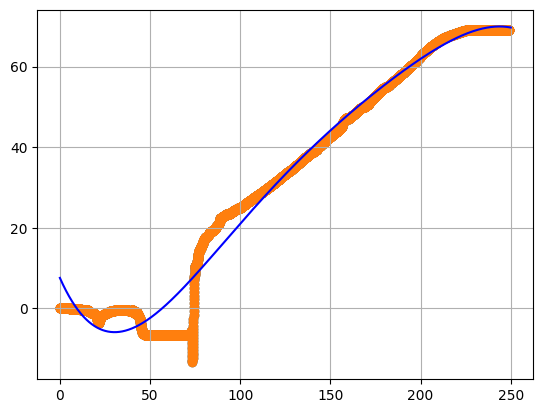

In [ ]:
# X AXIS POSITON
y=X[:,0]
x=time
plt.scatter(x, y)
modelx = np.poly1d(np.polyfit(x, y, 5)) #fifth degree polynomial
#Data scatterplot
polyline = np.linspace(0, 250, 6210)
plt.scatter(x, y)
#add fitted polynomial lines to scatterplot
plt.plot(polyline, modelx(polyline), color='blue')
plt.grid()
plt.show()
modelx = modelx(polyline)


# Y AXIS POSITON
y=X[:,1]
x=time
plt.scatter(x, y)
modely = np.poly1d(np.polyfit(x, y, 5)) #fifth degree polynomial
#Data scatterplot
polyline = np.linspace(0, 250, 6210)
plt.scatter(x, y)
#add fitted polynomial lines to scatterplot
plt.plot(polyline, modely(polyline), color='blue')
plt.grid()
plt.show()
modely = modely(polyline)


# Z AXIS POSITON
y=X[:,2]
x=time
plt.scatter(x, y)
modelz = np.poly1d(np.polyfit(x, y, 5)) #fifth degree polynomial
#Data scatterplot
polyline = np.linspace(0, 250, 6210)
plt.scatter(x, y)
#add fitted polynomial lines to scatterplot
plt.plot(polyline, modelz(polyline), color='blue')
plt.grid()
plt.show()
modelz = modelz(polyline)


It was found that the polynomial that most fitted the data was a fifth-degree polynomial. You can see how the polynomial fits the data better outside the tunnel while inside the 2 functions are distant. To see better the difference between the two functions, we zoomed the tunnel's section.

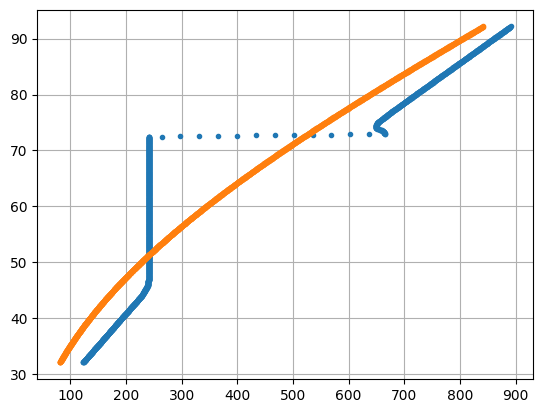

In [ ]:
gpsxg = gpsx[800:2300]
gpsyg = gpsy[800:3000]
gpszg = gpsz[800:2300]


modelxg = modelx[800:2300]
modelyg = modely[800:3000]
modelzg = modelz[800:2300]


plt.plot(gpsxg,time[800:2300], '.')
plt.plot(modelxg,time[800:2300], '.')
plt.grid()
plt.show()


To estimate the distance between the two functions, we compute the mean square error (MSE).

In [ ]:
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error

#Compute the MSE of the 3 axis

mse = mean_squared_error(X[:,0], modelx)
print('MSE axis x=\n', mse)

mse = mean_squared_error(X[:,1], modely)
print('MSE axis y=\n',mse)

mse = mean_squared_error(X[:,2], modelz)
print('MSE axis z=\n',mse)

MSE axis x=
 2952.327570764102
MSE axis y=
 529.1943935237325
MSE axis z=
 16.092518397064527


We could see that the values oh the MSE for the three axes is very high, due to the big difference in the tunnel how already mentioned.

# Designing the Algorithm
To initialize the algoritym, we need to set up the matrices. The first one is the vector state. This vector contains the variables we use to. Since uniformly accelerated motion was used, position, velocity and acceleration on the 3 axes were chosen as variables.

$V=
\begin{bmatrix}
x \\
y \\
z \\
\dot{x} \\
\dot{y} \\
\dot{z} \\
\ddot{x} \\
\ddot{y} \\
\ddot{z} \\
\end{bmatrix}$

The second one is the transition matrix ($F$). This one is used to set the physical law of motion. We used, as mentioned, uniformly accelerated motion being closer to our real motion. Let's remember the law of motion:

$\mathbf{x}$ = $\mathbf{x_0}$ + $\mathbf{v}$ $\Delta t$ + $\frac{1}{2}$ $\mathbf{a}$ $\Delta t^2$

The next one is the state transition matrix ($G$). This matrix needs to compute the process noise covariance matrix $Q$.

The $Q$ matrix represents process noise for the system model and the system model is an approximation. Throughout the life of a system state, that system model fluctuates in its accuracy. Therefore, the $Q$ matrix is used to represent this uncertainty and adds to the existing noise on the state. For this example, the systems actual accelerations and decelerations contribute to this error.

Then we have the state to measurement matrix $H$. The Kalman Filter uses the state-to-measurement matrix, $H$, to convert the system state estimate from the state space to the measurement space. For some applications, this is a matrix of zeros and ones. For other applications that use the Extended Kalman Filter, the $H$ matrix is populated with differential equations.

There are, then, the covariance matrices $R$, $P$. The first one is the measurement covariance matrix, the second one is the state covariance matrix.  

The $z$ is the measurment vector, the vector who contains the theorical value computed before.
In the end, we have $K$, the Kalman gain. The Kalman Filter computes a Kalman Gain for each new measurement that determines how much the input measurement will influence the system state estimate. In other words, when a really noisy measurement comes in to update the system state,in the our case in the tunnel,  the Kalman Gain will trust its current state estimate more than this new inaccurate information.
This concept is the root of the Kalman Filter algorithm and why it works. It can recognize how to properly weight its current estimate and the new measurement information to form an optimal estimate.

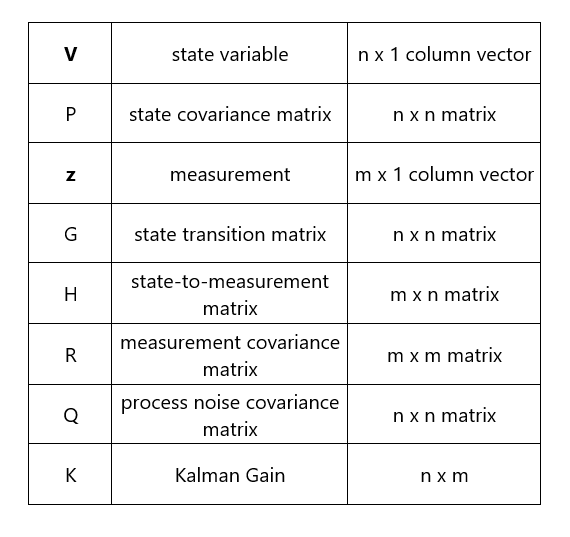

NOTE: On the Z-axis, acceleration due to gravity was not considered

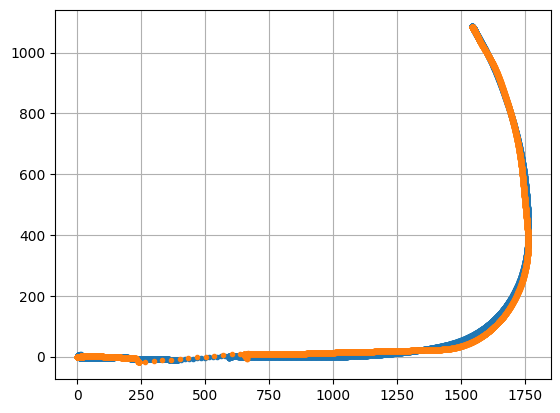

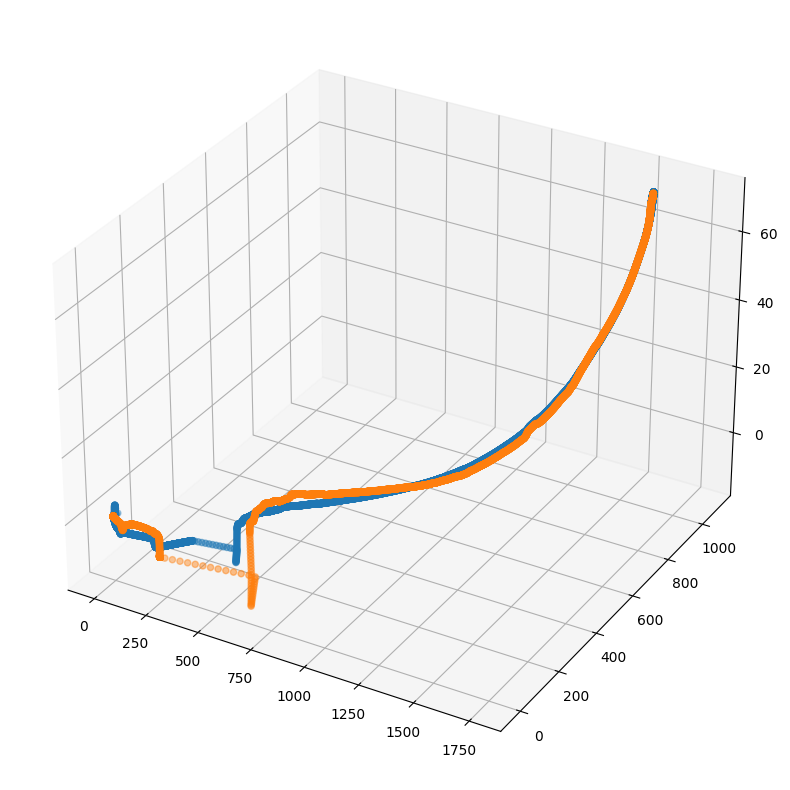

In [ ]:
!pip install filterpy
!pip install statistics


import statistics as st
import math
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.linalg import inv

#delta t
dt=(time[1]-time[0]) #0.04 s

#transition matrix
F = np.array([[1,0,0,dt,0,0,0.5*dt**2,0,0],[0,1,0,0,dt,0,0,0.5*dt**2,0],[0,0,1,0,0,dt,0,0,0.5*dt**2],[0,0,0,1,0,0,dt,0,0],
 [0,0,0,0,1,0,0,dt,0],[0,0,0,0,0,1,0,0,dt],[0,0,0,0,0,0,1,0,0], [0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]])


#state vector
state = np.array([gpsx,gpsy,gpsz,gpsxvel,gpsyvel,gpszvel,ax,ay,az]).T

#measurament vector
z = np.array([modelx,modely,modelz]).T

#state transition matrix
G = np.array([[0.5*dt], [0.5*dt], [0.5*dt], [dt], [dt], [dt],[1],[1],[1]])

#mean of the measured speeds
maxvelx, maxvely, maxvelz = max(gpsxvel), max(gpsyvel), max(gpszvel)
maxvel=[maxvelx, maxvely, maxvelz]
meanvel = st.mean(maxvel)

#speed variance
sigma_v = np.sqrt(meanvel)/3

#noise covariance matrix
Q = (G@G.T)*((sigma_v)**2)

#state to measurement matrix
H=np.array([[1,0,0,0,0,0,0,0,0],
 [0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0]])


#state covariance matrix
A = np.array([gpsx, gpsy, gpsz,gpsxvel, gpsyvel, gpszvel, ax, ay, az])
P = np.cov(A, bias=False)


#measurement covariance matrix
R = np.diag([st.variance(modelx), st.variance(modely), st.variance(modelx)])

#identical matrix
I = np.eye(9)

#Kalman algorithm
for i in range(0,6210):

  #PREDICT
  state[i], P = predict(state[i], P, F, Q)

  #UPDATE
  S = H@P@H.T + R
  K = (P@H.T@np.linalg.inv(S))
  y = z[i] - H@state[i]
  state[i] += K @ y
  P = (I - (K@H))@P*1.3

#Plots 2D and 3D
plt.plot(state[:,0], state[:,1] , '.')
plt.plot(X[:,0], X[:,1], '.')
plt.grid()
plt.show()

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(state[:,0], state[:,1],state[:,2])
ax1.scatter(X[:,0], X[:,1],X[:,2])


#  Results
We may note that the Kalman filter improves the position when the noise is quite, but in the tunnel, we can see only a small improvement because this filter is not the best due to the hyopethis of linearity and the gaussian one. Althought, we can see an improvement of MSE.

 To increase the filtering, in the update step, we have added a moltiplicative factor (1.3) to give more weight to theorical data.

In [ ]:
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error

#Remember the old MSE of the 3 axis

mse = mean_squared_error(X[:,0], modelx)
print('MSE axis x=\n', mse)

mse = mean_squared_error(X[:,1], modely)
print('MSE axis y=\n',mse)

mse = mean_squared_error(X[:,2], modelz)
print('MSE axis z=\n',mse)

MSE axis x=
 2952.327570764102
MSE axis y=
 529.1943935237325
MSE axis z=
 16.092518397064527


In [ ]:
#Compute the new MSE of the 3 axis between Kalman and polynomial

msex = mean_squared_error(state[:,0], modelx)
print('MSE axis x=\n', msex)

msey = mean_squared_error(state[:,1], modely)
print('MSE axis y=\n', msey)

msez = mean_squared_error(state[:,2], modelz)
print('MSE axis z=\n', msez)


MSE axis x=
 613.996252193441
MSE axis y=
 109.9037870022493
MSE axis z=
 3.5334454134762128


In [ ]:
#Compute the new MSE of the 3 axis between Kalman and data

msex = mean_squared_error(state[:,0], X[:,0])
print('MSE axis x=\n', msex)

msey = mean_squared_error(state[:,1], X[:,1])
print('MSE axis y=\n', msey)

msez = mean_squared_error(state[:,2], X[:,2])
print('MSE axis z=\n', msez)

MSE axis x=
 873.9725780854806
MSE axis y=
 157.13954110835653
MSE axis z=
 4.686910027183646


# Study of acceleration frequencies
In the second part of the project, we want to put an emphasis on acceleration and its frequencies. In a first time, we plotted the graph of acceleration versus time on the three axes.


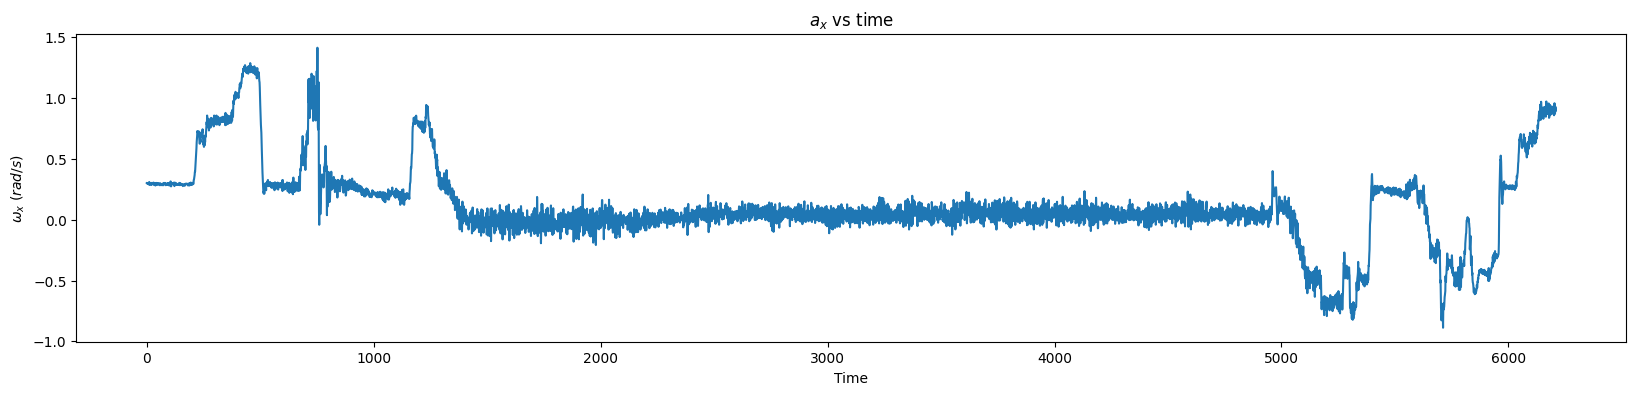

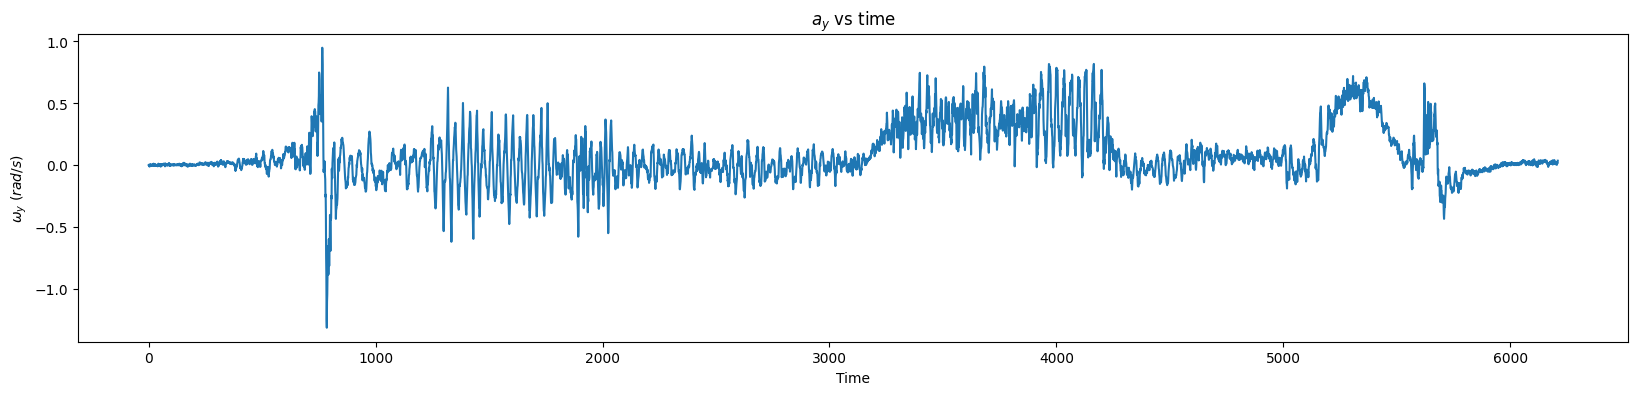

Text(0.5, 0, 'Time')

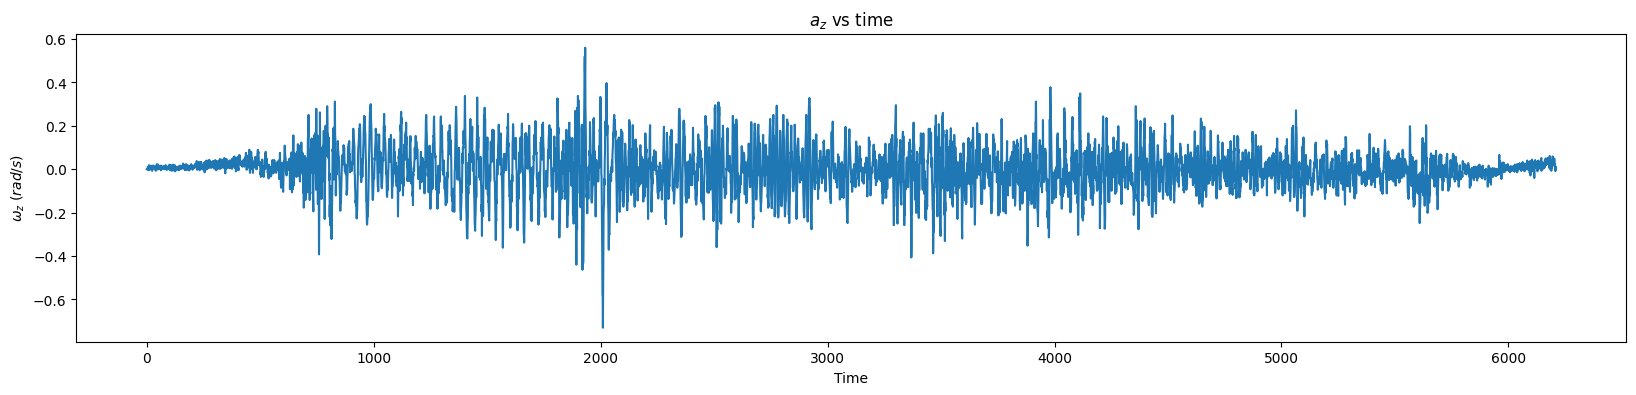

In [ ]:
!pip install scaleogram
import pywt
import random
import scaleogram as scg
import seaborn as sns

#Plot acceleration vs time on 3 axes

ax1 = ax.plot(y="$\omega_x$", use_index=True,figsize=(20,4), title='$a_x$ vs time',legend=False,)
ax1.set_ylabel("$\omega_x$ ($rad/s$)")
ax1.set_xlabel("Time")
plt.show()

ax2 = ay.plot(y="$\omega_y$",use_index=True,figsize=(20,4), title='$a_y$ vs time',legend=False,)
ax2.set_ylabel("$\omega_y$ ($rad/s$)")
ax2.set_xlabel("Time")
plt.show()

ax3 = az.plot(y="$\omega_z$",use_index=True,figsize=(20,4), title='$a_z$ vs time',legend=False,)
ax3.set_ylabel("$\omega_z$ ($rad/s$)")
ax3.set_xlabel("Time")

Later, the Fast Fourier Transform (FFT) has been used to analyze the frequencies. With the FFT, we shell pass from the times spatial domain to the frequencies spatial domain. In particular, we could see the variations in acceleration in the period about 5000. Through the Fourier Transform, there is an increase in the frequency of acceleration on $y$ and an decrease on $x$. This is due to the presence of a curve on the section considered, as can be seen when compared to the position graph.

To better see the change in frequency, the Wavelet transform has been used, in particular the scaleogram, which emphasizes an higher frequency concentration in this section.

  Preparing metadata (setup.py) ... done
  Created wheel for fft: filename=fft-0.1-py3-none-any.whl size=1132 sha256=dacfe161ecc2eedd0089bc87757319cb91bab123401320be3ec661d0cd1ba5a4
  Stored in directory: /root/.cache/pip/wheels/f2/70/4f/91ec7b0bea7d1150b77242a9f4ec63ea551ab464a8561f9fb5
Successfully built fft


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


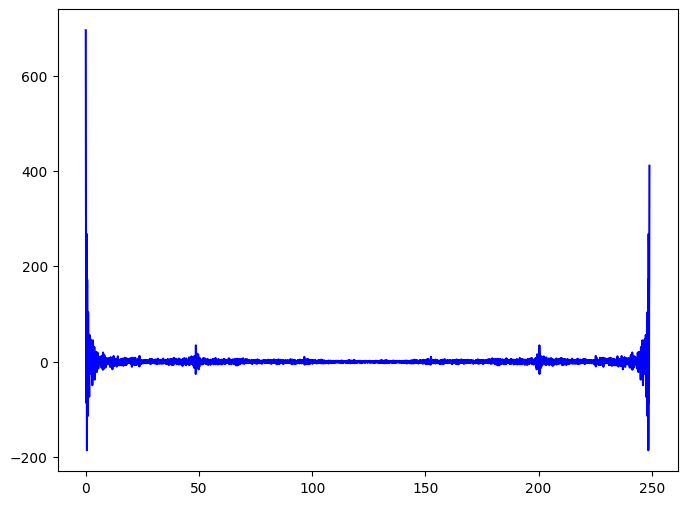

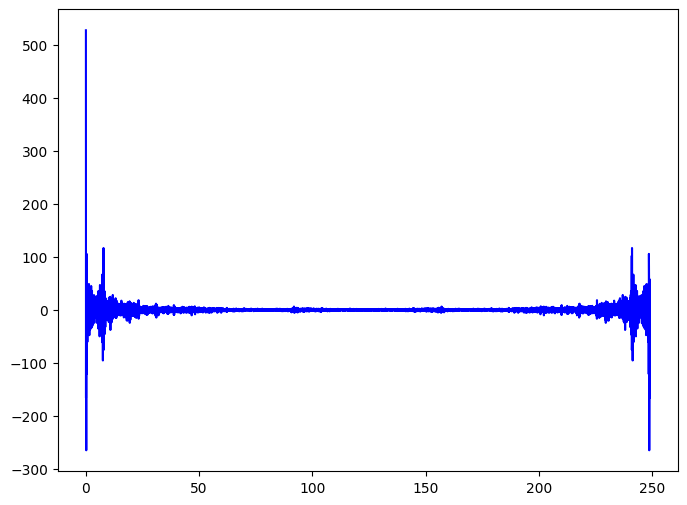

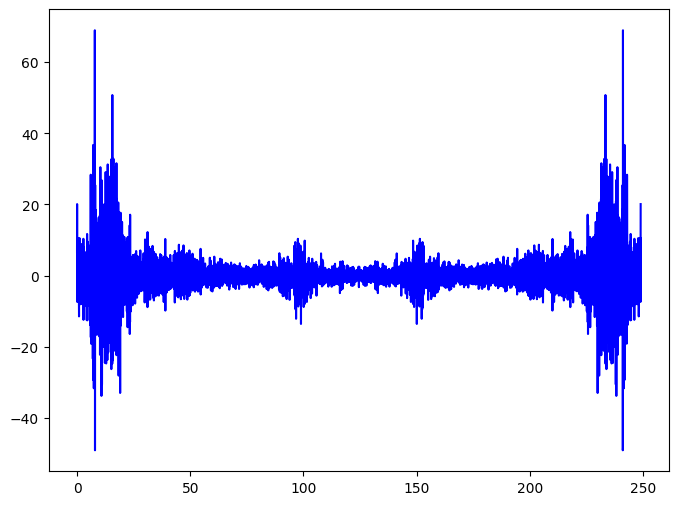

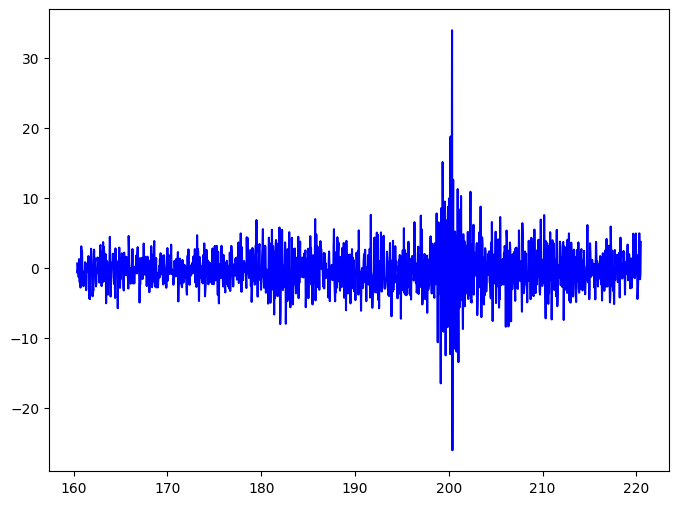

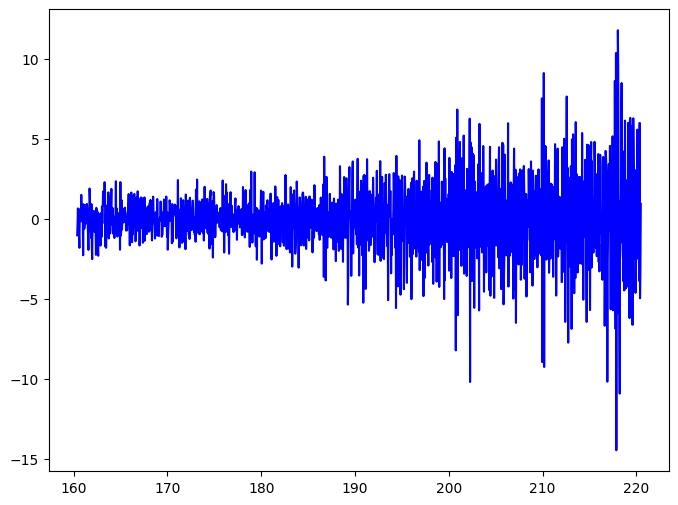

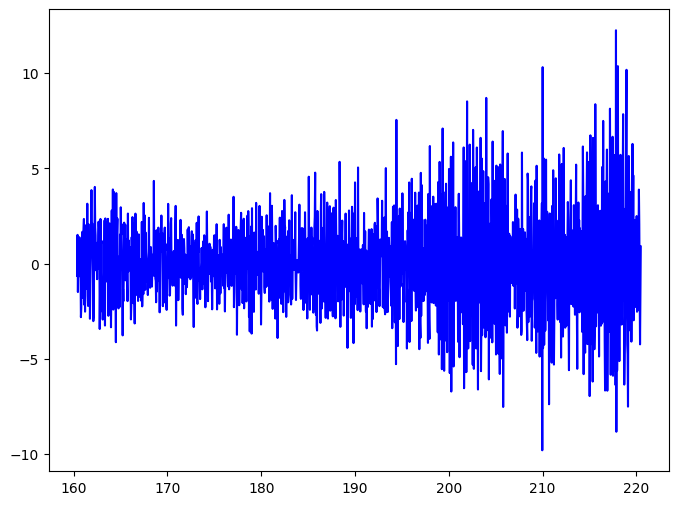

In [ ]:
!pip install fft
from scipy.fftpack import fft
import scaleogram as scg

#Compute the FFTs on the 3 axes
Fx=fft(ax.values)
plt.figure(figsize = (8, 6))
plt.plot(time,Fx,'b', label='Fft')
plt.show()

Fy=fft(ay.values)
plt.figure(figsize = (8, 6))
plt.plot(time,Fy,'b', label='Fft')
plt.show()

Fz=fft(az.values)
plt.figure(figsize = (8, 6))
plt.plot(time,Fz,'b', label='Fft')
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(time[4000:5500],Fx[4000:5500],'b', label='Fft')
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(time[4000:5500],Fy[4000:5500],'b', label='Fft')
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(time[4000:5500],Fz[4000:5500],'b', label='Fft')
plt.show()


# Scaleogram
A scaleogram is a 2D representation of 1D data with:


* X time axis;
* Y scale axis. (The scale corresponds to the periodicity signal that the transform identifies);
* A gradient corresponding to the amplitude of the change in the measured signal. (These variations are placed at time X with periodicity Y).

*Warning: to run the code and not have problems, modify the cws code in scalogram: transform the alpha parameter by removing the quotes ('0.5'=>0.5)*

TypeError: alpha must be numeric or None, not a string

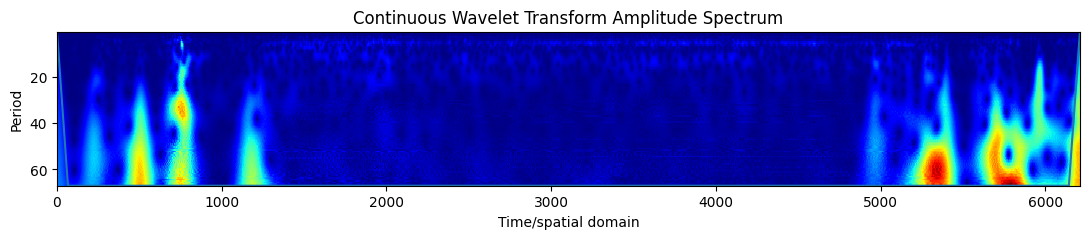

In [ ]:
#Scaleogram of x-axis
scx = scg.cws(ax, figsize=(13.2, 2))

TypeError: alpha must be numeric or None, not a string

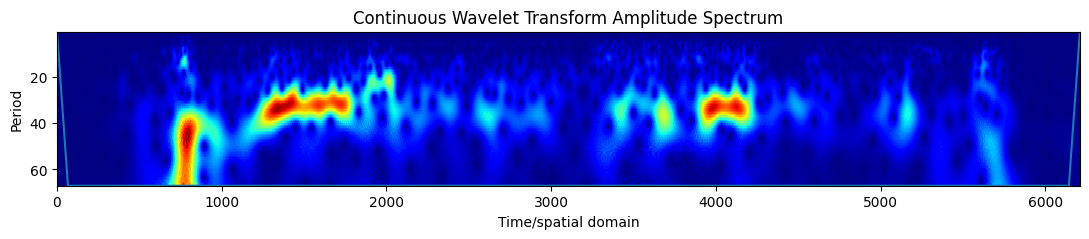

In [ ]:
#Scaleogram of y-axis
scy = scg.cws(ay, figsize=(13.2, 2))

TypeError: alpha must be numeric or None, not a string

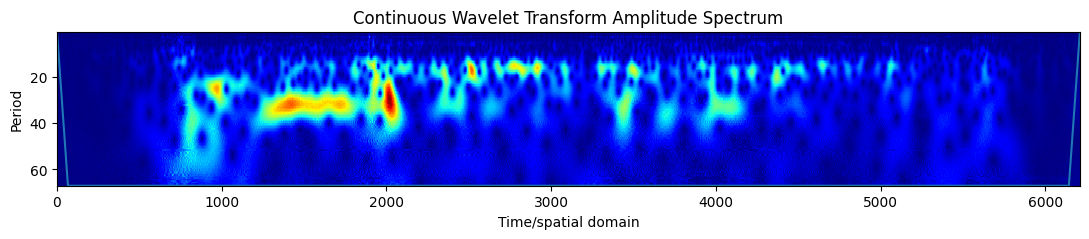

In [ ]:
#Scaleogram of z-axis
scz = scg.cws(az, figsize=(13.2, 2))


As observed previously, through the FFT, with the red areas we notice an increase in intensity due to the curve

In order to reduce the component of the curve on acceleration, which as seen causes a change in frequencies, a high-pass or low-pass filter was used. The filters have been applied to the FFT and to show the results in the time spatial domain, we applied the inverse Fourier Trasforms (IFFT). To better show the results, the scaleogram of acceleration on the 3 axes was made. You can see how the frequencies are more uniform.

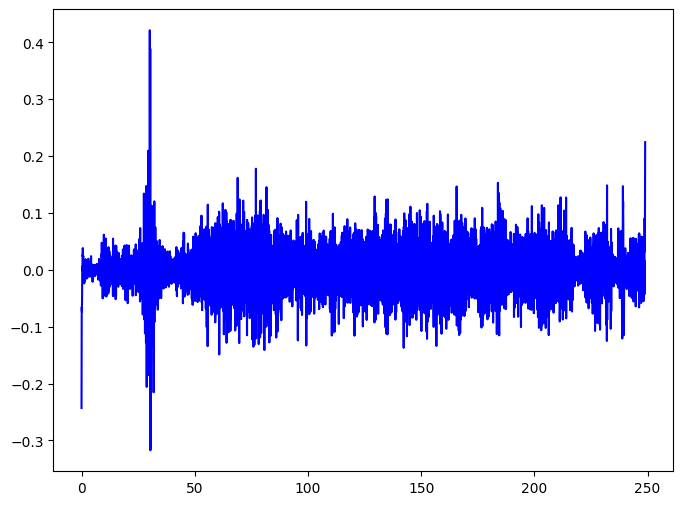

TypeError: alpha must be numeric or None, not a string

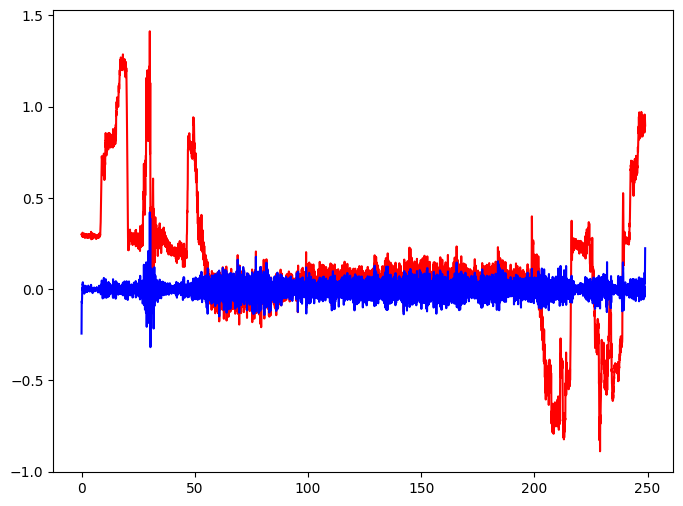

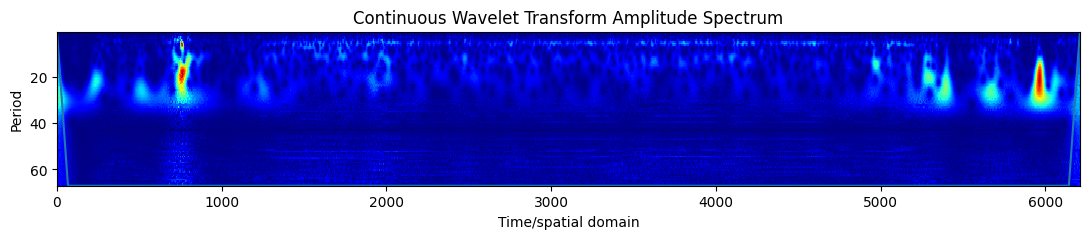

In [ ]:
#Apply FFT
Fx=fft(ax.values)
n = len(time)
freq = np.fft.fftfreq(n, 1/time)

#Create a frequency filter
freq_cutoff= 8

#Apply the filter
high_freq_filter = (np.abs(freq) >= freq_cutoff).astype(int)

high_freq_filter = high_freq_filter[:]

filtered_fft = Fx * high_freq_filter

#Inverse FFT
filteredx = np.fft.ifft(filtered_fft)

#Plot the waveform and spectrum
plt.figure(figsize = (8, 6))
plt.plot(time,filteredx,'b', label='Fft')
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(time, ax,'r', label='Fft')
plt.plot(time,filteredx,'b', label='Fft')

scx = scg.cws(filteredx, figsize=(13.2, 2))


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


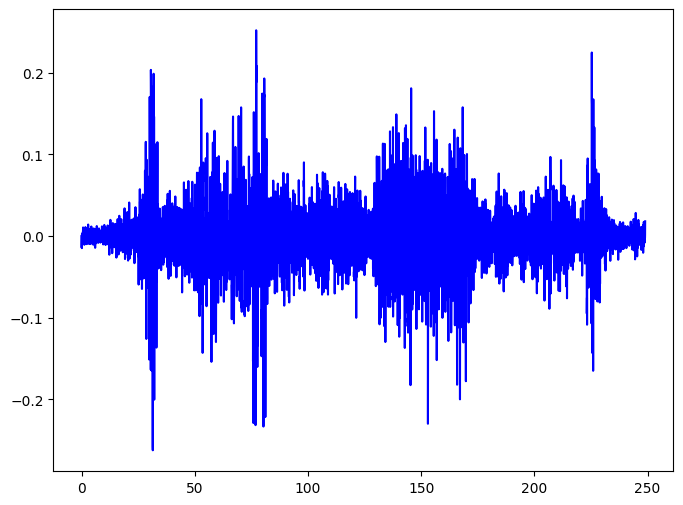

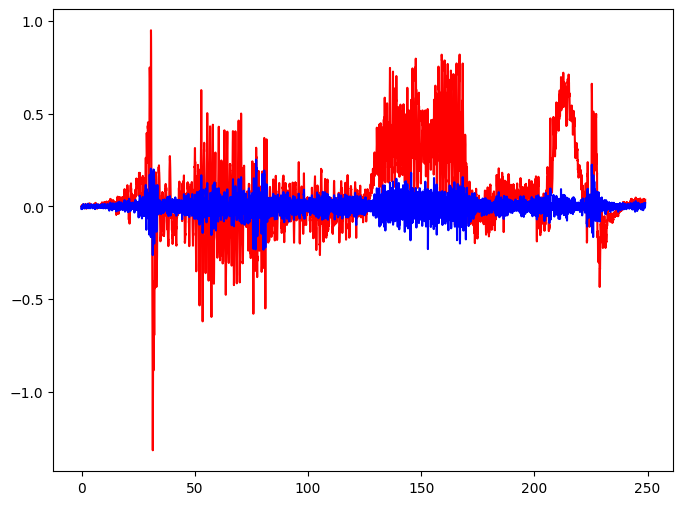

TypeError: alpha must be numeric or None, not a string

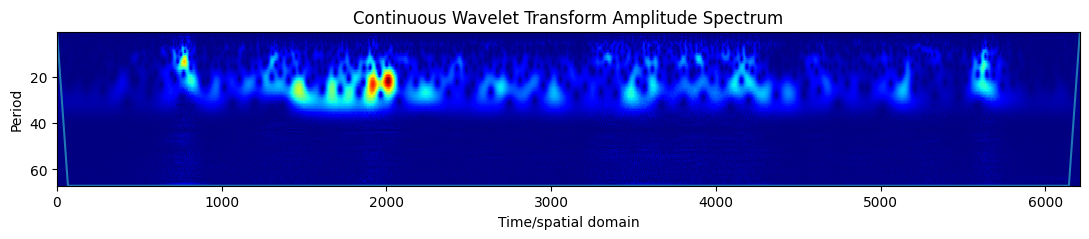

In [ ]:
#Apply FFT
Fy=fft(ay.values)
n = len(time)
freq = np.fft.fftfreq(n, 1/time)

#Create a frequency filter
freq_cutoff= 8

#Apply the filter
high_freq_filter = (np.abs(freq) >= freq_cutoff).astype(int)

high_freq_filter = high_freq_filter[:]

filtered_fft = Fy * high_freq_filter

#Inverse FFT
filteredy = np.fft.ifft(filtered_fft)

#Plot the waveform and spectrum
plt.figure(figsize = (8, 6))
plt.plot(time,filteredy,'b', label='Fft')


plt.figure(figsize = (8, 6))
plt.plot(time,ay,'r', label='Fft')
plt.plot(time,filteredy,'b', label='Fft')

plt.show()

scx = scg.cws(filteredy, figsize=(13.2, 2))

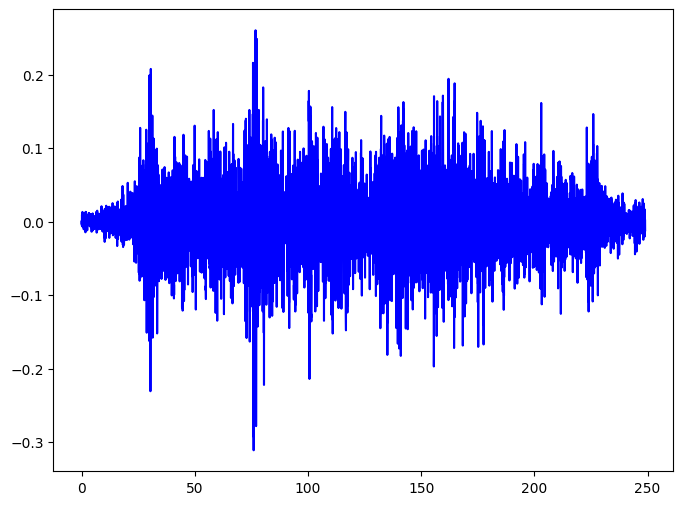

TypeError: alpha must be numeric or None, not a string

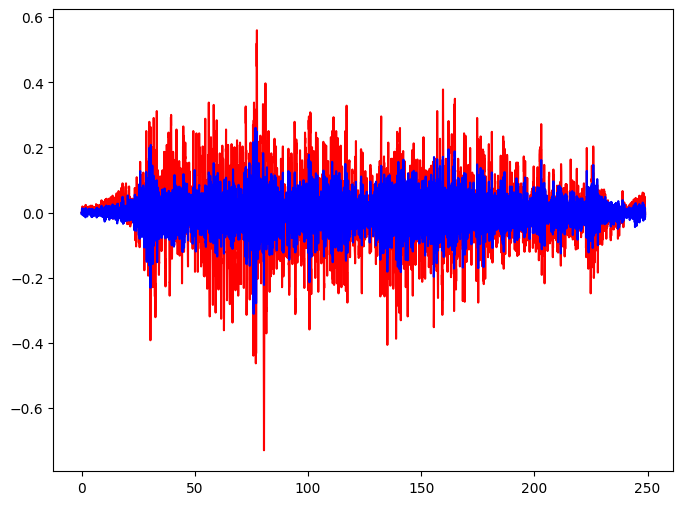

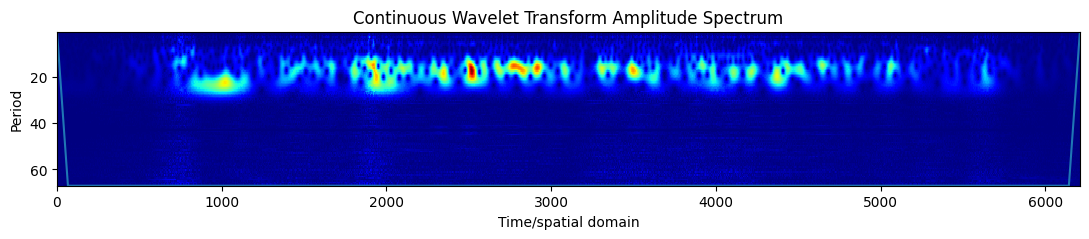

In [ ]:
#Apply FFT
Fz=fft(az.values)
n = len(time)
freq = np.fft.fftfreq(n, 1/time)

#Create a frequency filter
freq_cutoff= 10

#Apply the filter
high_freq_filter = (np.abs(freq) >= freq_cutoff).astype(int)

high_freq_filter = high_freq_filter[:]

filtered_fft = Fz * high_freq_filter

#Inverse FFT
filteredz = np.fft.ifft(filtered_fft)

#Plot the waveform and spectrum
plt.figure(figsize = (8, 6))
plt.plot(time,filteredz,'b', label='Fft')
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(time,az,'r', label='Fft')
plt.plot(time,filteredz,'b', label='Fft')

scx = scg.cws(filteredz, figsize=(13.2, 2))

# Conclusions
The application of the Kalman filter on the train position data did not lead to excellent results, especially in the tunnel part. This is because the Kalman filter is not suitable for this type of problem, where other Bayesian filters that manage non-linear and non-Gaussian systems are preferred (e.g. particle filter). Secondly, the frequencies representing the acceleration on bends were searched for using the FFT. These high frequencies arise from the presence of imperfections in the train track. For this reason, through classic filtering techniques we have reduced the component of the curve, obtaining excellent results.

**References**
1. https://it.mathworks.com/help/fusion/gs/spatial-representation-coordinate-systems-and-conventions
2. https://liqul.github.io/blog/assets/rotation.pdf
3. https://ieeexplore.ieee.org/document/6082908
4. https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
5. https://medium.com/@jaems33/understanding-kalman-filters-with-python-2310e87b8f48
6. http://ais.informatik.uni-freiburg.de/teaching/ws13/mapping/pdf/slam03-bayes-filter-short.pdf
7. https://github.com/alsauve/scaleogram/blob/master/doc/scale-to-frequency.ipynb
8. https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
9. https://gist.github.com/junzis/e06eca03747fc194e322
10. https://github.com/Manu-Fraile/Kalman-Filtering
11. https://medium.com/@mathiasmantelli/kalman-filter-part-2-bayes-filter-f2fa9c0b5c95
12. https://thekalmanfilter.com/kalman-filter-explained-simply/#:~:text=The%20Kalman%20Filter%20uses%20theis%20populated%20with%20differential%20equations.